In [2]:
%matplotlib inline
import sys
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde

In [3]:
## automatically reload any modules read below that might have changed (e.g. plots)
%reload_ext autoreload
%autoreload 2
# importing plotting and locus tools: 
sys.path.append('../src')
sys.path.append('../paper/notebooks')
import LocusTools as lt
import PlotTools as pt
import paperPlots as pp

## read Stripe 82 SDSS-Gaia data for plots...   

In [4]:
datafile = '../data/Stripe82GaiaEDR3.csv'
s82gaia = Table.read(datafile) 
# reddening corrected SDSS colors
df = s82gaia
df['Ar'] = df['AR_val']
C = lt.extcoeff()
for b in ['u', 'g', 'i', 'z']:  
    df['A'+b] = C[b]*df['Ar']  
# and now apply reddening corrections
df['ug'] = df['u_mMed'] - df['g_mMed'] - (df['Au']-df['Ag'])
df['gr'] = df['g_mMed'] - df['r_mMed'] - (df['Ag']-df['Ar'])
df['ri'] = df['r_mMed'] - df['i_mMed'] - (df['Ar']-df['Ai'])
df['iz'] = df['i_mMed'] - df['z_mMed'] - (df['Ai']-df['Az'])
df['gi'] = df['gr'] + df['ri'] 
df['rmag'] = df['r_mMed']
# for plots, wrapped RA
ra = df['ra_gaia'] 
df['raW'] = np.where(ra > 180, ra-360, ra)

In [5]:
## a few subsamples for plots
# u flux limit (and r band - but just one source rejected)
rMax = 22.0
uMin = 12.0 
uMax = 22.0 
flag = (s82gaia['r_mMed']<rMax)&(s82gaia['u_mMed']>uMin)&(s82gaia['u_mMed']<uMax) 
s82gaiaB = s82gaia[flag]
# for fitting MS and giants
flag = (s82gaiaB['gi']>0.2)&(s82gaiaB['gi']<3.5)
s82gaiaPhD = s82gaiaB[flag]
# good parallax distance
piSNR = s82gaia['pi']/s82gaia['piErr']
s82gaiaPi = s82gaia[piSNR > 20]  
print(len(s82gaia), len(s82gaiaB), len(s82gaiaPhD), len(s82gaiaPi))

841200 415279 409312 63102


## empirical SDSS locus 

In [6]:
datafile = '../data/LocusData/MSandRGBcolors_v1.3.txt'
Lok = lt.LSSTsimsLocus(fixForStripe82=True, datafile=datafile)
print(np.min(Lok['FeH']), np.max(Lok['FeH']))

Fixing input Mr-FeH-colors grid to agree with the SDSS v4.2 catalog
-2.5 0.0


In [7]:
# for plotting, sequences for 3 values of FeH
# selecting a few tracks at fixed metallicity
FeH0 =  0.5
FeH1 = -1.5
FeH2 = -2.5
L0 = Lok[(Lok['FeH']>FeH0-0.01)&(Lok['FeH']<FeH0+0.01)]
L1 = Lok[(Lok['FeH']>FeH1-0.01)&(Lok['FeH']<FeH1+0.01)]
L2 = Lok[(Lok['FeH']>FeH2-0.01)&(Lok['FeH']<FeH2+0.01)]
Ls = []
Ls.append(L0)
Ls.append(L1)
Ls.append(L2)
FeHlocus3vals = [FeH0, FeH1, FeH2]

## 1) extend SDSS locus to 0 < FeH < 0.5 range

In [8]:
locusExtendedHighFeH = lt.extendLocusHighFeH(Lok)
len(locusExtendedHighFeH)

176961

In [9]:
locusSDSS = locusExtendedHighFeH[locusExtendedHighFeH['Mr']<16.001]
len(locusSDSS)

103761

SDSS, FeH range: -2.5 0.0
Extended FeH range: -2.5 0.5
made plot: compare2isochrones_SDSSorigSDSSextendedFeH.png


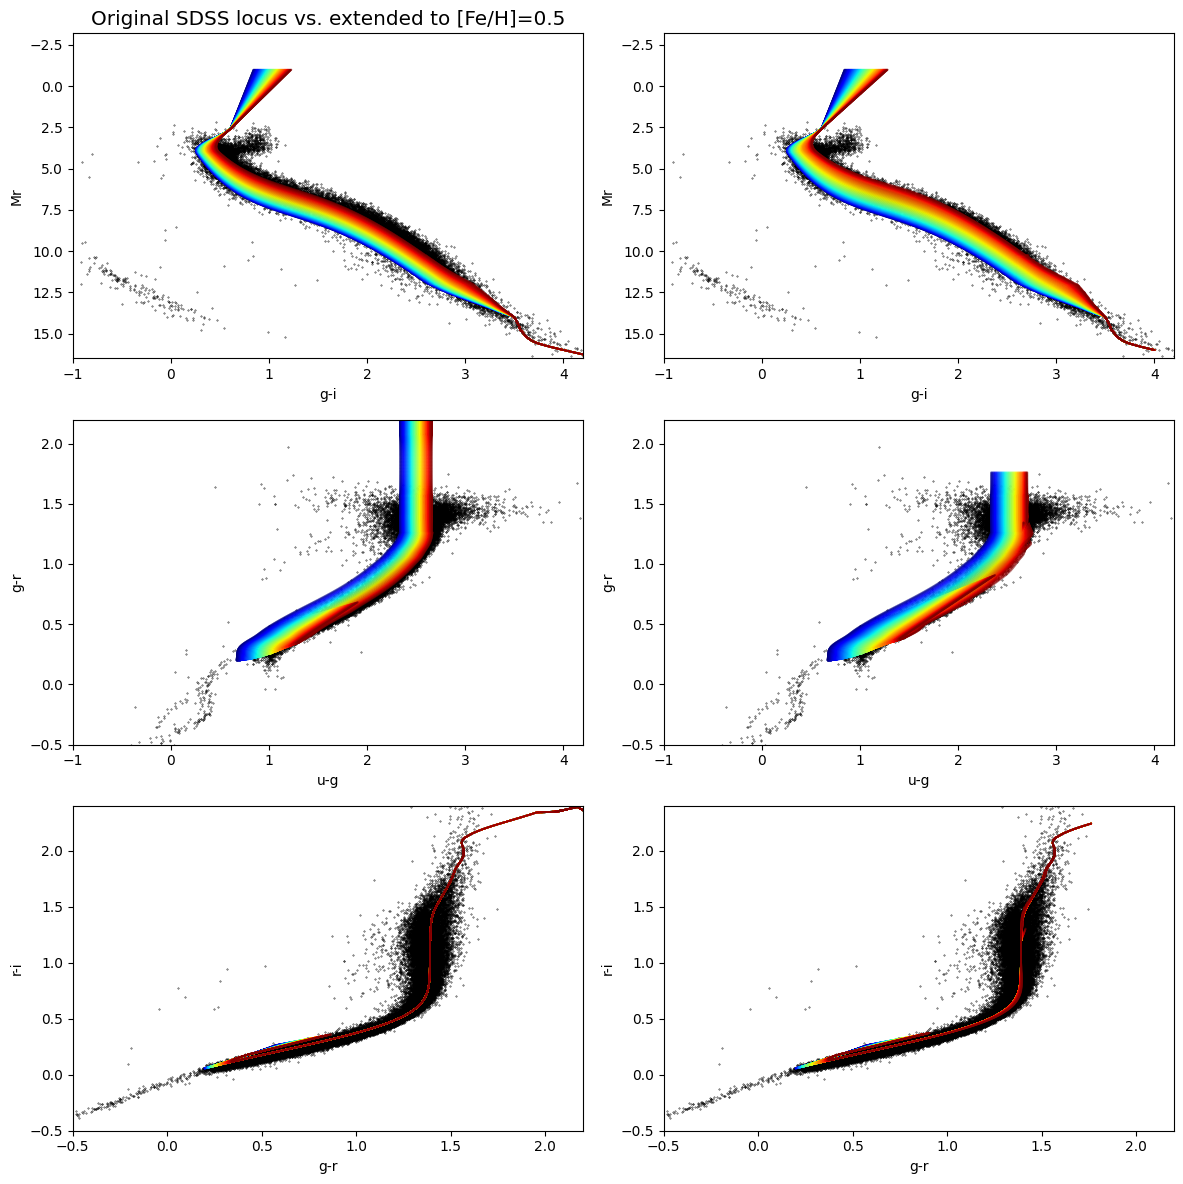

In [10]:
Pdf1 = Lok
Pdf2 = locusSDSS
print('SDSS, FeH range:', np.min(Pdf1['FeH']), np.max(Pdf1['FeH']))
print('Extended FeH range:', np.min(Pdf2['FeH']), np.max(Pdf2['FeH']))
pname = 'compare2isochrones_SDSSorigSDSSextendedFeH.png'
title = 'Original SDSS locus vs. extended to [Fe/H]=0.5'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.4, alpha2=0.4, title=title, plotname=pname)

## new Dartmouth locus: Dartmouth Stellar Evolution Database (DSED)

In [11]:
DSEDdatadir = '../data/DSED/'
ages, FeHlist, DSEDiso, DSEDlocii = lt.readAllDSED(DSEDdatadir) 

Text(0, 0.5, 'Mr')

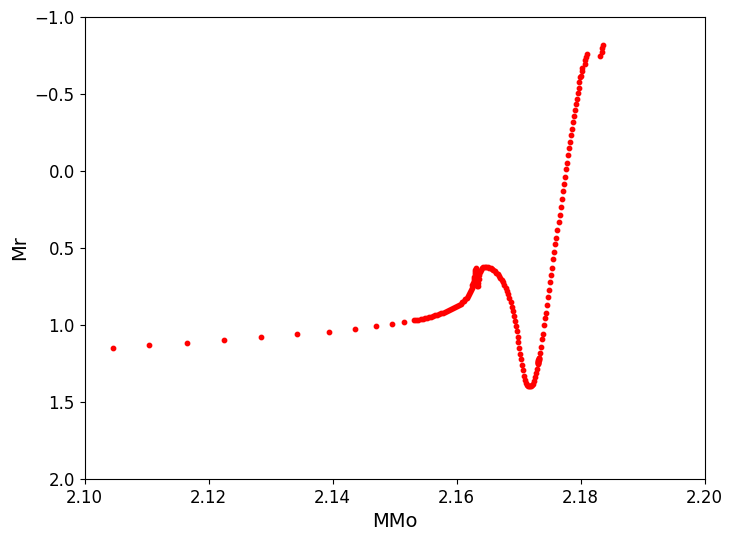

In [12]:
df = DSEDiso[2][0]
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(df['MMo'], df['Mr'], c='red', s=10) 
ax.set_xlim(2.1,2.2)
ax.set_ylim(2, -1.0)
ax.set_xlabel('MMo')
ax.set_ylabel('Mr') 


Text(0, 0.5, 'ug, gr, ri')

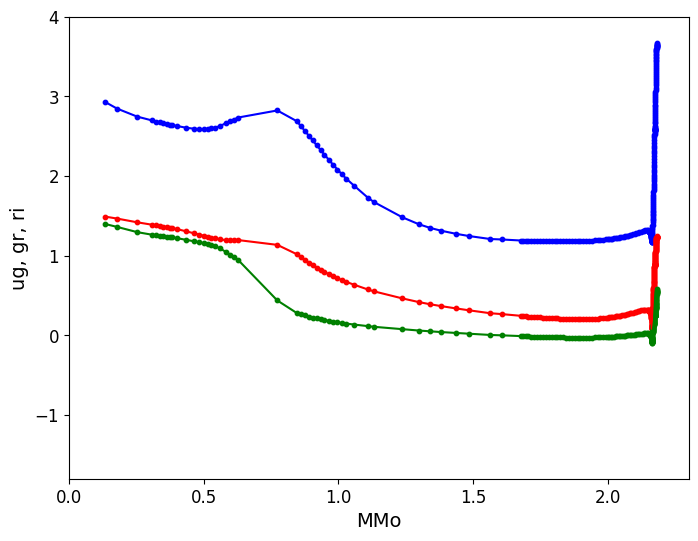

In [13]:
df = DSEDiso[2][0]
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(df['MMo'], df['ug'], c='blue', s=10) 
ax.scatter(df['MMo'], df['gr'], c='red', s=10) 
ax.scatter(df['MMo'], df['ri'], c='green', s=10) 
ax.plot(df['MMo'], df['ug'], c='blue') 
ax.plot(df['MMo'], df['gr'], c='red') 
ax.plot(df['MMo'], df['ri'], c='green') 
ax.set_xlim(0.0,2.3)
ax.set_ylim(-1.8, 4.0)
ax.set_xlabel('MMo')
ax.set_ylabel('ug, gr, ri') 


Text(0, 0.5, 'ug, gr, ri')

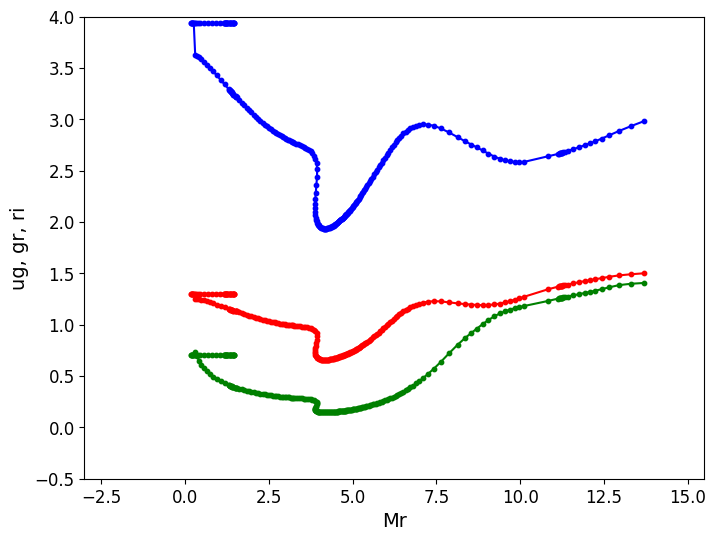

In [14]:
df = DSEDiso[ages.index(10)][0]
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(df['Mr'], df['ug'], c='blue', s=10) 
ax.scatter(df['Mr'], df['gr'], c='red', s=10) 
ax.scatter(df['Mr'], df['ri'], c='green', s=10) 
ax.plot(df['Mr'], df['ug'], c='blue') 
ax.plot(df['Mr'], df['gr'], c='red') 
ax.plot(df['Mr'], df['ri'], c='green') 
ax.set_xlim(-3.0, 15.5)
ax.set_ylim(-0.5, 4.0)
ax.set_xlabel('Mr')
ax.set_ylabel('ug, gr, ri') 


made plot: compare2isochronesColorMr_SDSS_vs_DSED_10Gyr.png


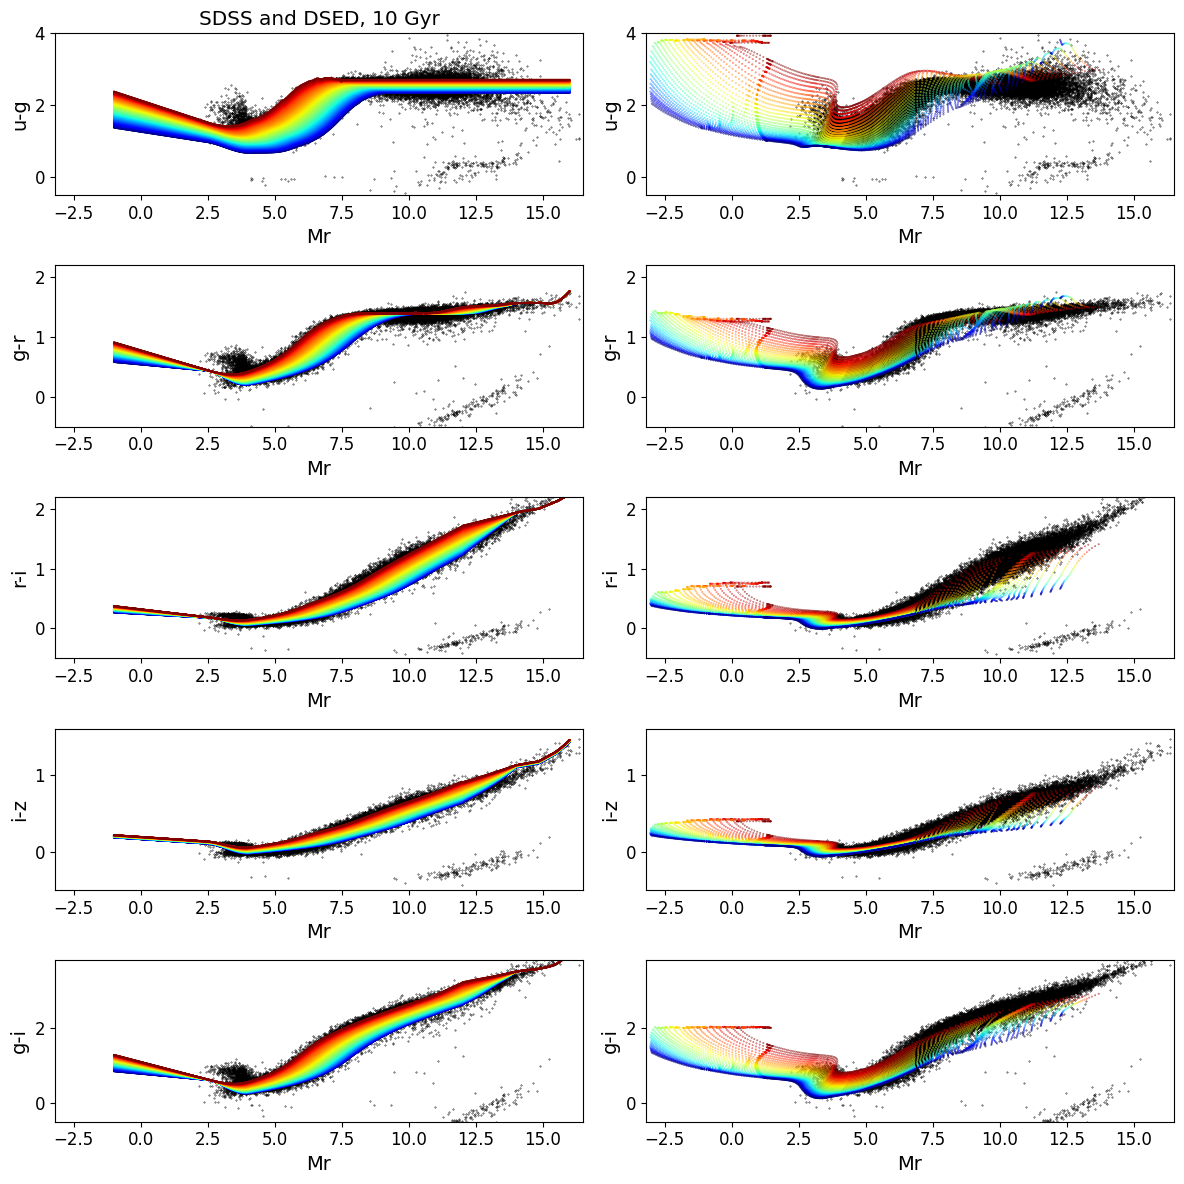

In [15]:
Pdf1 = locusSDSS
Pdf2 = DSEDlocii[ages.index(10)] 
pname = 'compare2isochronesColorMr_SDSS_vs_DSED_10Gyr.png'
title = 'SDSS and DSED, 10 Gyr'
pp.compare2isochronesColorMr(s82gaiaPi, Pdf1, Pdf2, alpha1=0.8, alpha2=0.8, title=title, plotname=pname)

made plot: compare2isochrones_SDSS_vs_DSED_10Gyr.png


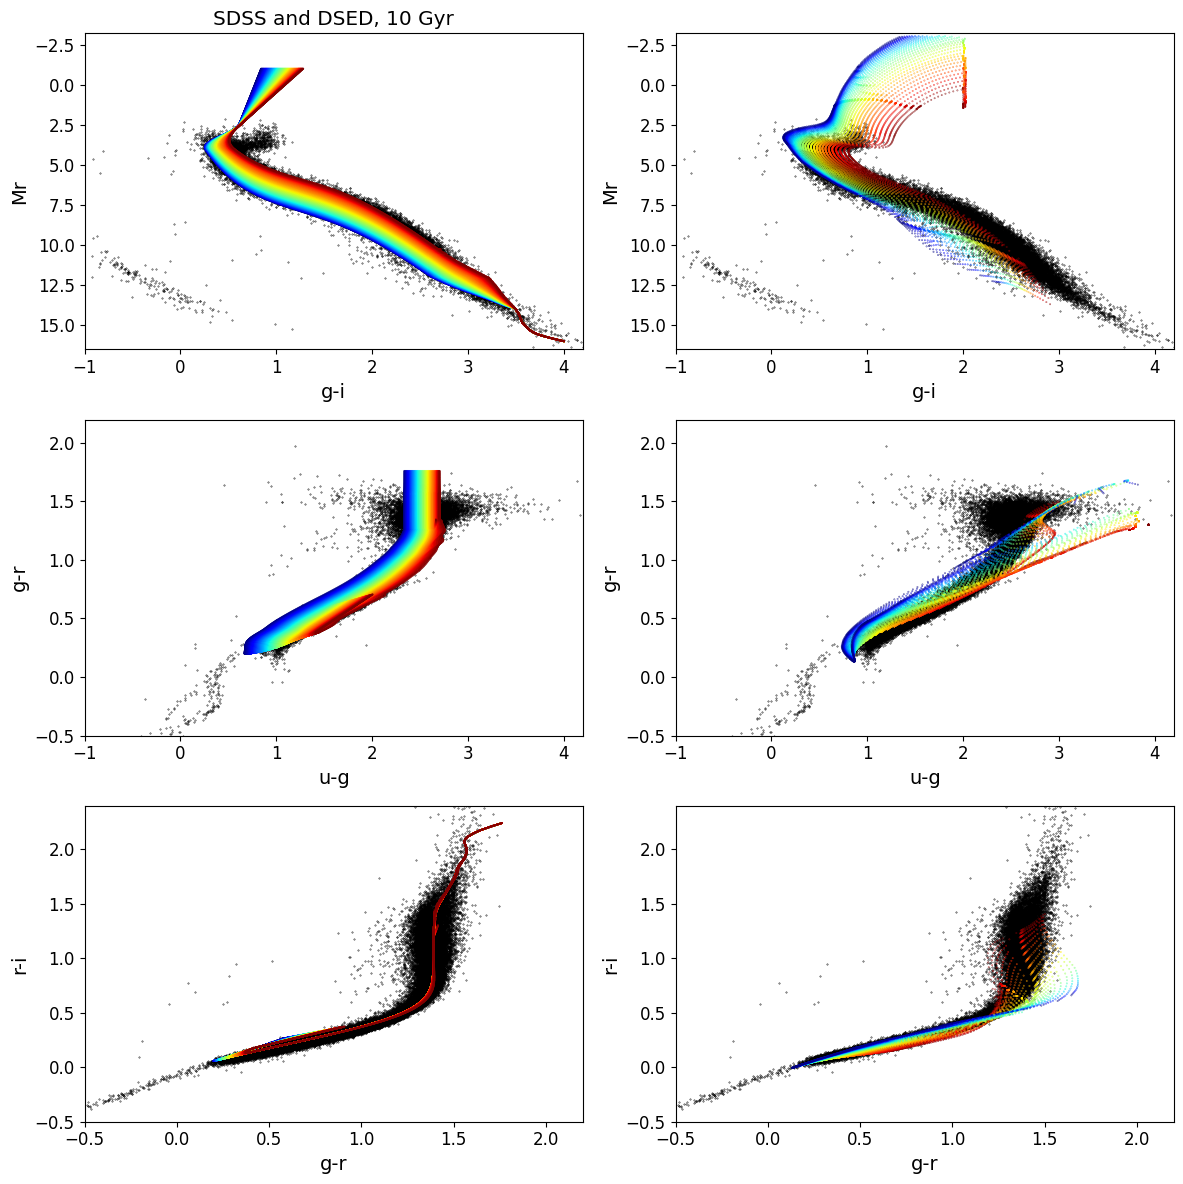

In [16]:
Pdf1 = locusSDSS
Pdf2 = DSEDlocii[ages.index(10)] 
pname = 'compare2isochrones_SDSS_vs_DSED_10Gyr.png'
title = 'SDSS and DSED, 10 Gyr'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.8, alpha2=0.8, title=title, plotname=pname)

## "smooth" isochrones

In [17]:
DSEDisoFixed1 = lt.fixDSEDlist(DSEDiso[ages.index(1)], Mr1=0.0, Mr2=1.5)
DSEDlociiFixed1 = lt.DSEDlist2locus(DSEDisoFixed1) 

In [18]:
DSEDisoFixed10 = lt.fixDSEDlist(DSEDiso[ages.index(10)], Mr1=0.0, Mr2=1.5)
DSEDlociiFixed10 = lt.DSEDlist2locus(DSEDisoFixed10) 

## test the "smoothing" result

made plot: compare2isochronesColorMr_DSED_1Gyr_vs_1GyrFixed.png


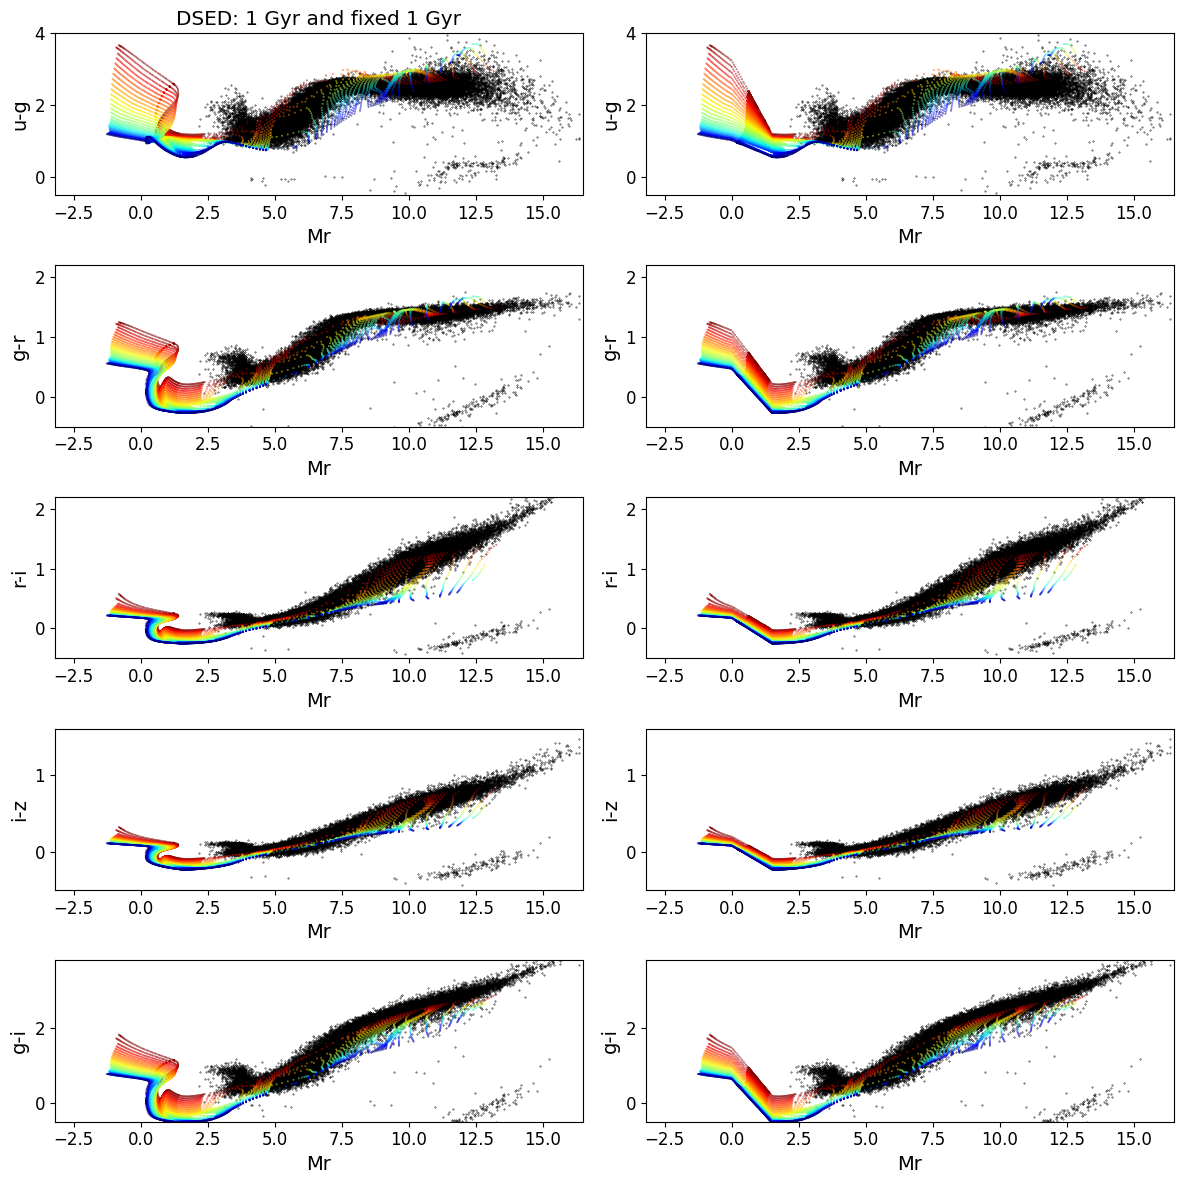

In [19]:
Pdf1 = DSEDlocii[ages.index(1)] 
Pdf2 = DSEDlociiFixed1  
pname = 'compare2isochronesColorMr_DSED_1Gyr_vs_1GyrFixed.png'
title = 'DSED: 1 Gyr and fixed 1 Gyr'
pp.compare2isochronesColorMr(s82gaiaPi, Pdf1, Pdf2, alpha1=0.8, alpha2=0.8, title=title, plotname=pname)

made plot: compare2isochronesColorMr_DSED_10Gyr_vs_10GyrFixed.png


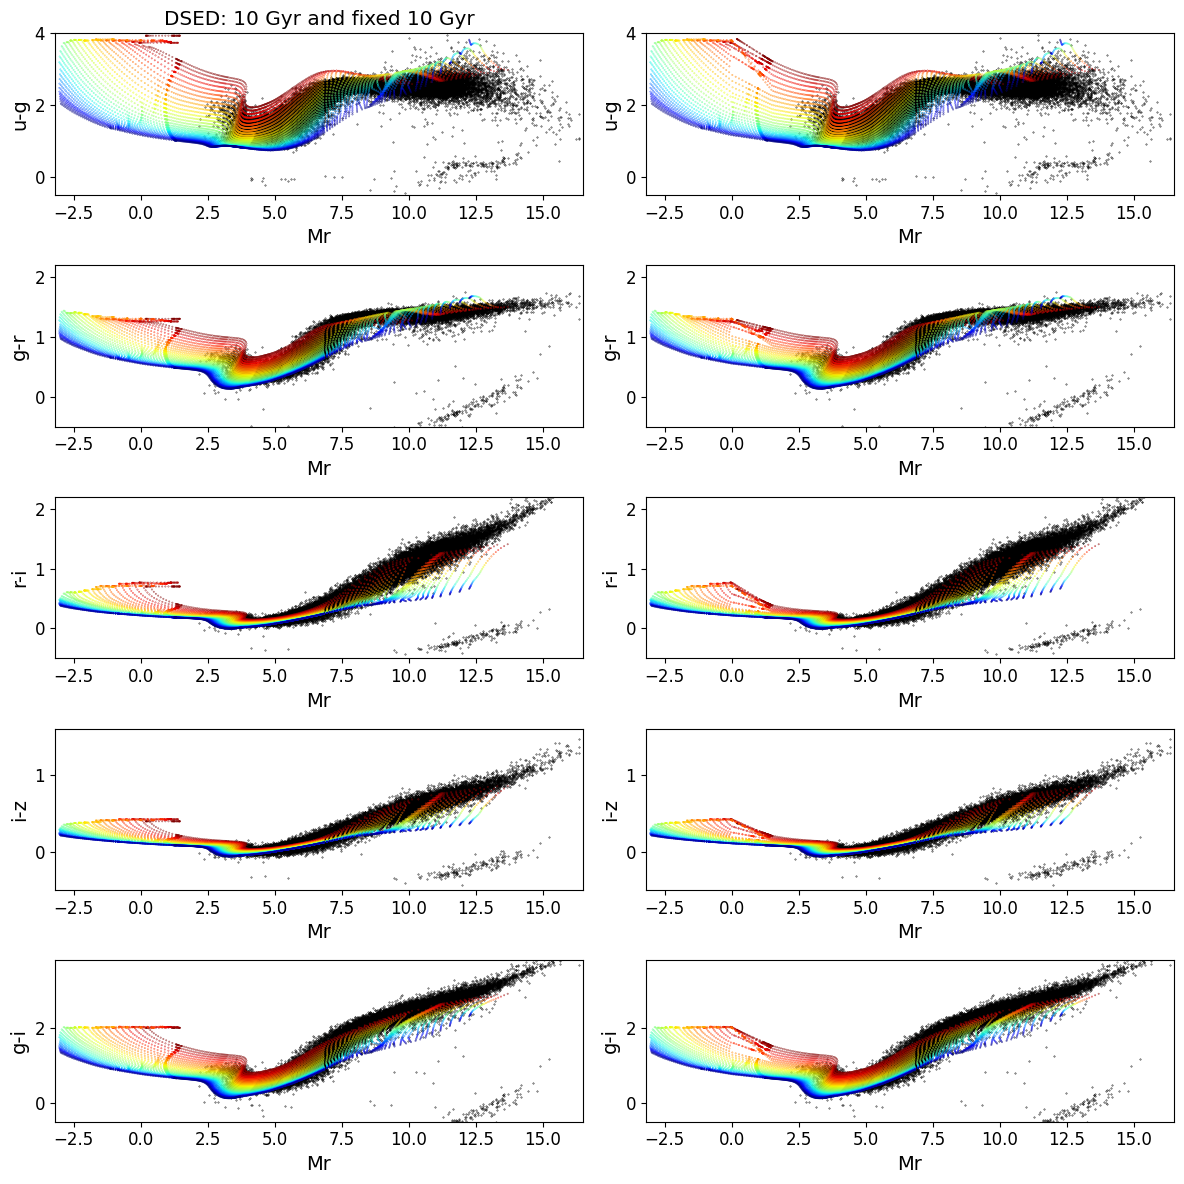

In [20]:
Pdf1 = DSEDlocii[ages.index(10)] 
Pdf2 = DSEDlociiFixed10  
pname = 'compare2isochronesColorMr_DSED_10Gyr_vs_10GyrFixed.png'
title = 'DSED: 10 Gyr and fixed 10 Gyr'
pp.compare2isochronesColorMr(s82gaiaPi, Pdf1, Pdf2, alpha1=0.8, alpha2=0.8, title=title, plotname=pname)

made plot: compare2isochronesColorMr_DSED_1Gyr_vs_1GyrFixed.png


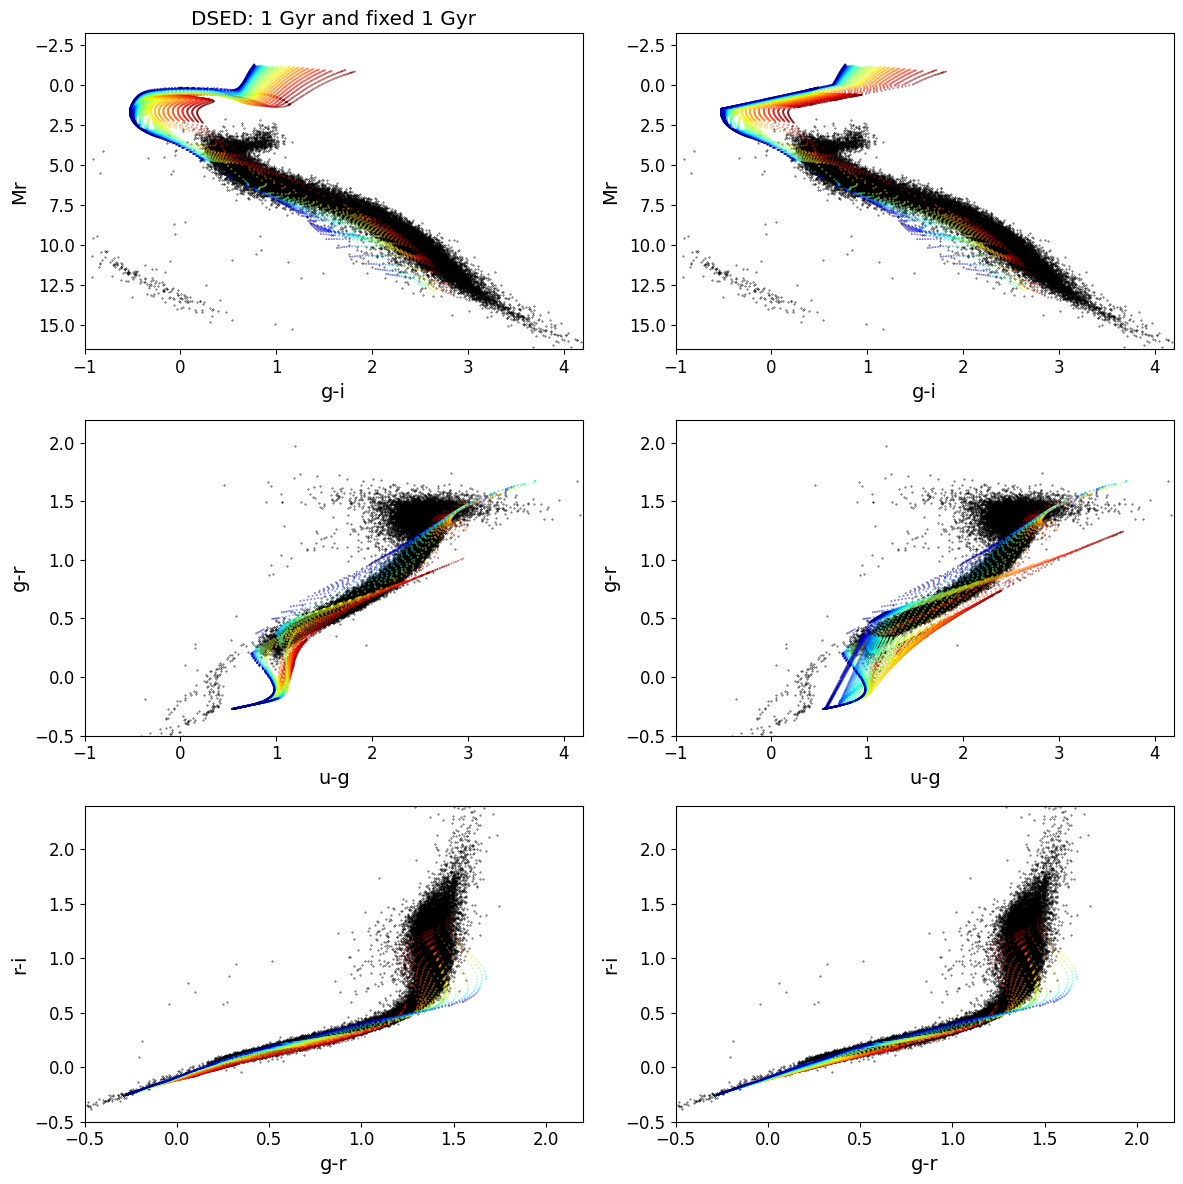

In [21]:
Pdf1 = DSEDlocii[ages.index(1)] 
Pdf2 = DSEDlociiFixed1  
pname = 'compare2isochronesColorMr_DSED_1Gyr_vs_1GyrFixed.png'
title = 'DSED: 1 Gyr and fixed 1 Gyr'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.8, alpha2=0.8, title=title, plotname=pname)

made plot: compare2isochronesColorMr_DSED_10Gyr_vs_10GyrFixed.png


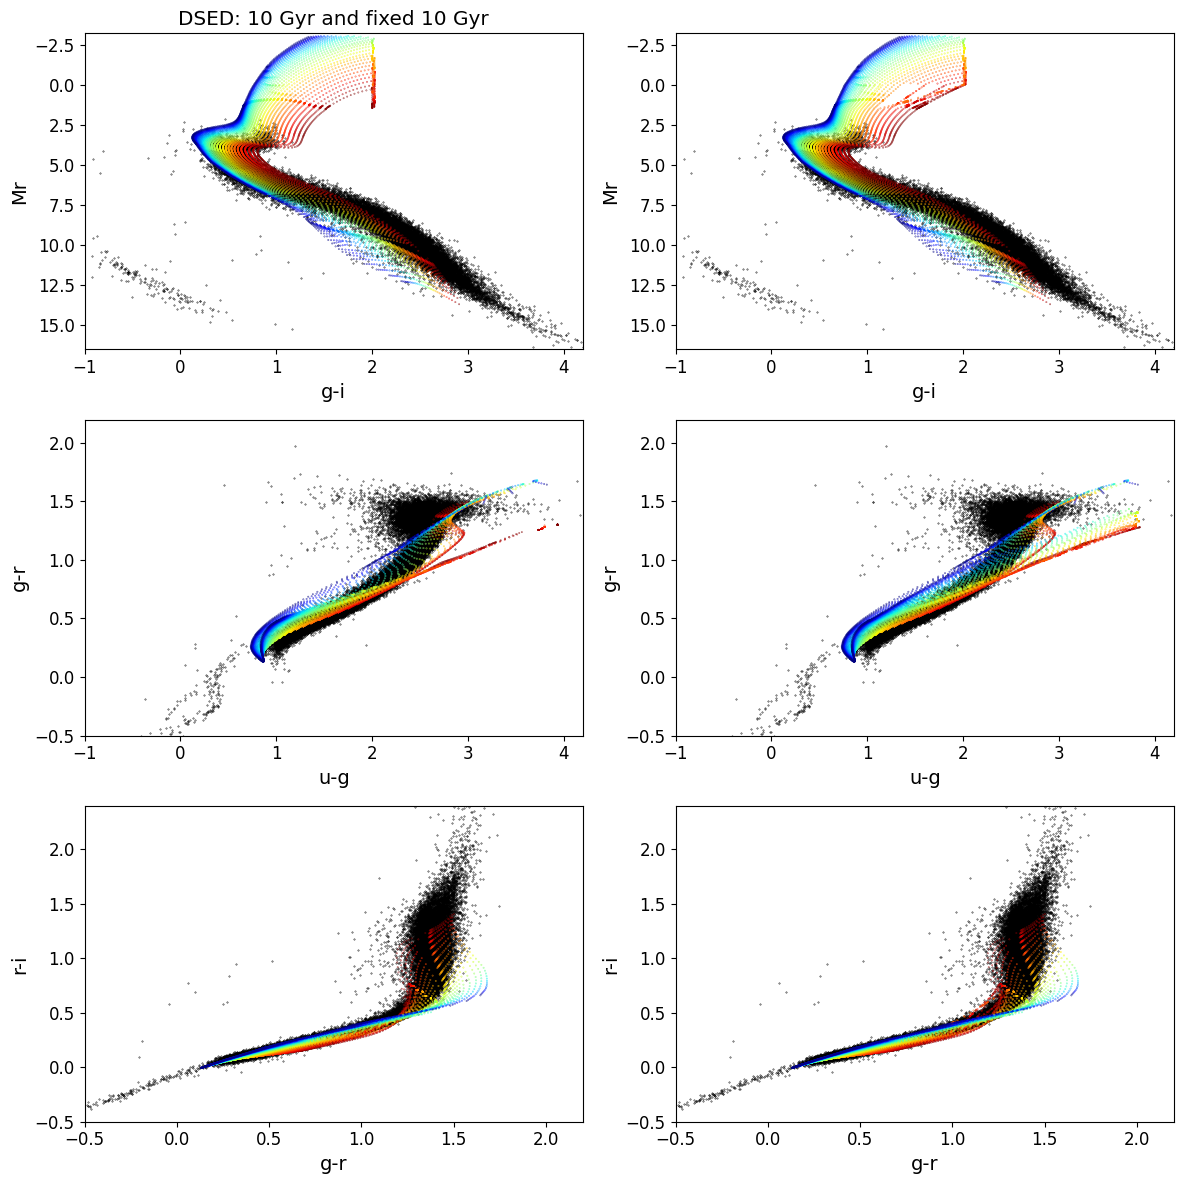

In [22]:
Pdf1 = DSEDlocii[ages.index(10)] 
Pdf2 = DSEDlociiFixed10 
pname = 'compare2isochronesColorMr_DSED_10Gyr_vs_10GyrFixed.png'
title = 'DSED: 10 Gyr and fixed 10 Gyr'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.8, alpha2=0.8, title=title, plotname=pname)

In [23]:
DSEDlociiAug = lt.makeDSEDlociiAugmented(DSEDiso)

augmenting isochrone: 0 (out of 15 )
augmenting isochrone: 1 (out of 15 )
augmenting isochrone: 2 (out of 15 )
augmenting isochrone: 3 (out of 15 )
augmenting isochrone: 4 (out of 15 )
augmenting isochrone: 5 (out of 15 )
augmenting isochrone: 6 (out of 15 )
augmenting isochrone: 7 (out of 15 )
augmenting isochrone: 8 (out of 15 )
augmenting isochrone: 9 (out of 15 )
augmenting isochrone: 10 (out of 15 )
augmenting isochrone: 11 (out of 15 )
augmenting isochrone: 12 (out of 15 )
augmenting isochrone: 13 (out of 15 )
augmenting isochrone: 14 (out of 15 )


made plot: compare2isochrones_DSED_1Gyr_10Gyr_fineMrGrid.png


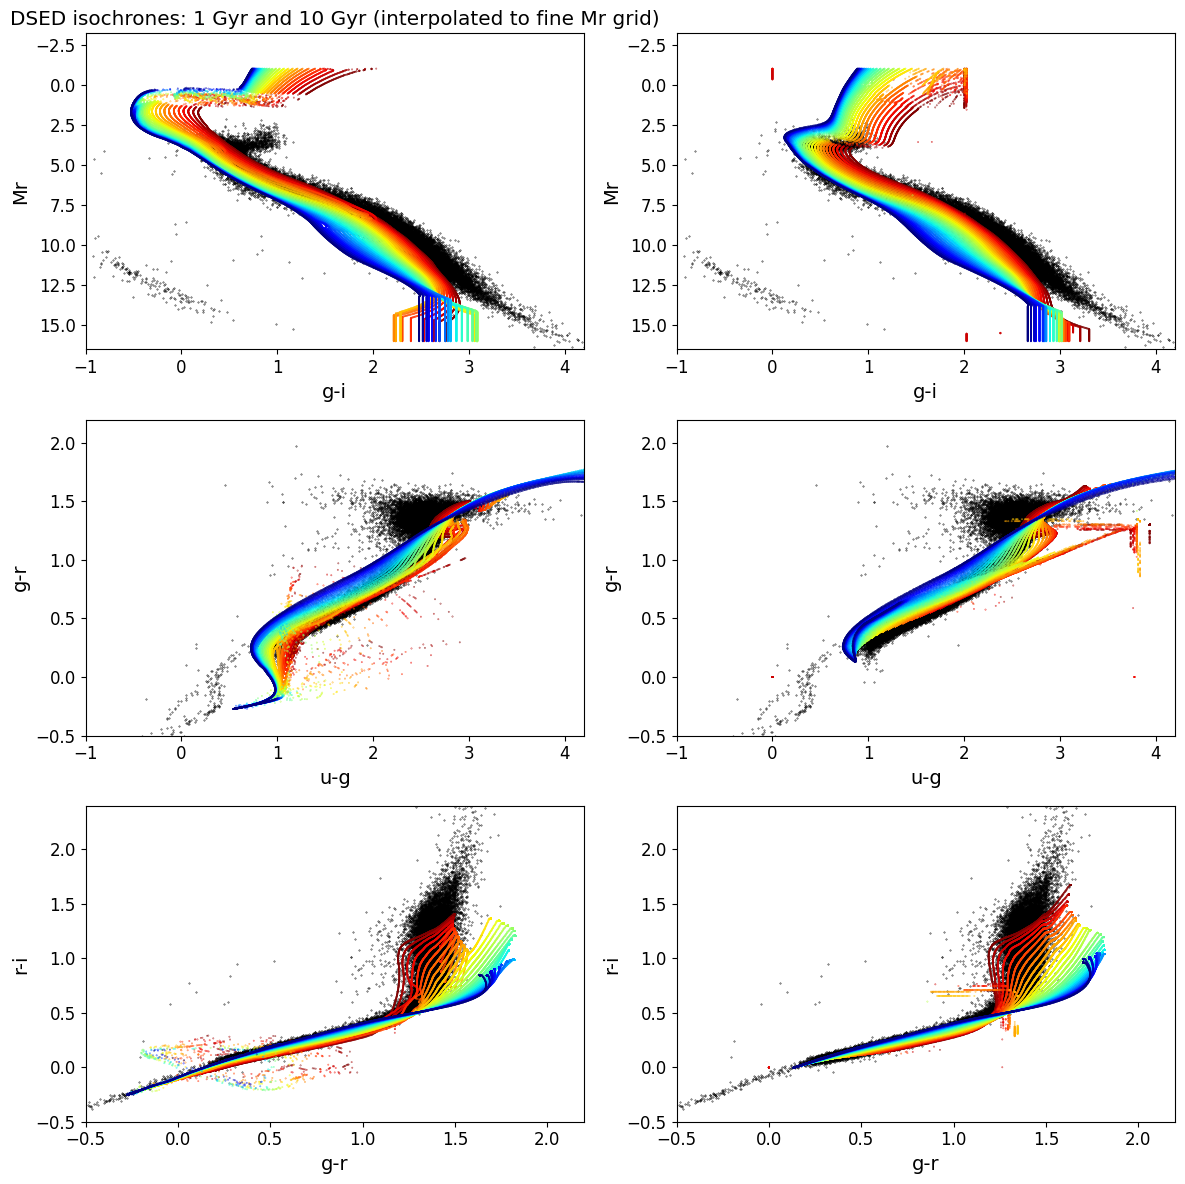

In [24]:
Pdf1 = DSEDlociiAug[ages.index(1)]
Pdf2 = DSEDlociiAug[ages.index(10)]
Pdf1['gi'] = Pdf1['gr'] + Pdf1['ri']
Pdf2['gi'] = Pdf2['gr'] + Pdf2['ri']
pname = 'compare2isochrones_DSED_1Gyr_10Gyr_fineMrGrid.png'
title = 'DSED isochrones: 1 Gyr and 10 Gyr (interpolated to fine Mr grid)'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.8, alpha2=0.8, title=title, plotname=pname)

### interpolate DSED to SDSS grid

In [25]:
#DSEDlociiInterp = lt.interpolateDSED2masterLocus(DSEDlociiAug, locusSDSS)
DSEDlociiInterp = lt.interpolateDSED2masterLocus(DSEDlocii, locusSDSS)

In [26]:
locusDSED1 = DSEDlociiInterp[ages.index(1)]
locusDSED10 = DSEDlociiInterp[ages.index(10)]

In [27]:
len(locusSDSS), len(locusDSED1), len(locusDSED10)

(103761, 103761, 103761)

made plot: compare2isochrones_DSED_1Gyr_10Gyr_interpolated2SDSS.png


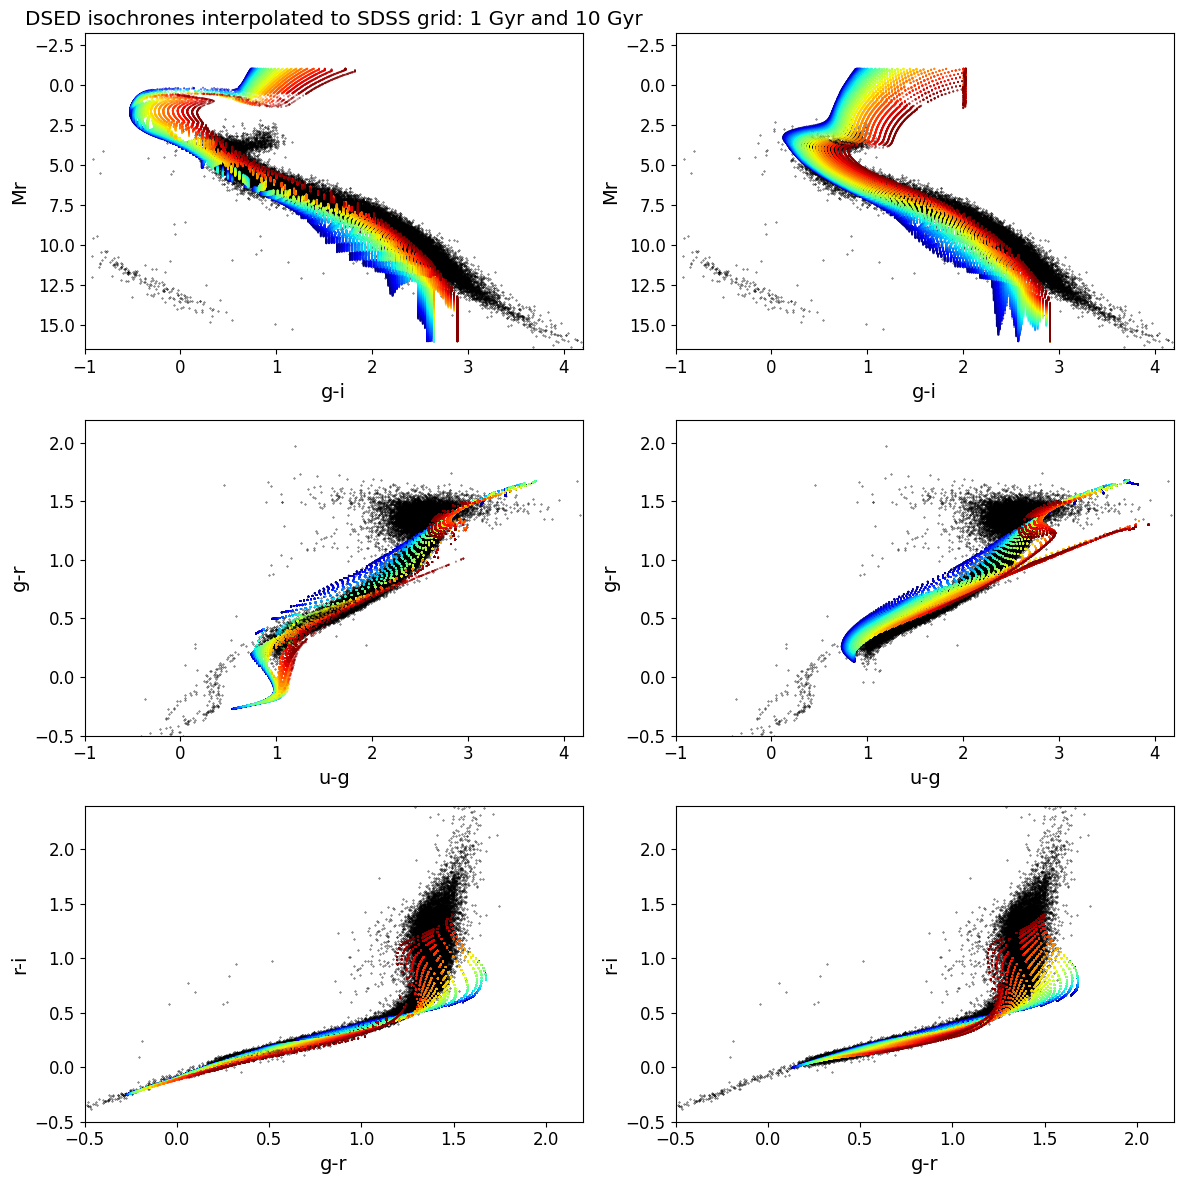

In [28]:
Pdf1 = locusDSED1
Pdf2 = locusDSED10 
pname = 'compare2isochrones_DSED_1Gyr_10Gyr_interpolated2SDSS.png'
title = 'DSED isochrones interpolated to SDSS grid: 1 Gyr and 10 Gyr'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.5, alpha2=0.5, title=title, plotname=pname)

## 2) replace Mr < 5 part with DSED isocrones

In [29]:
MrStitch = 4.0
locusSDSS1 = lt.augmentSDSSlocus(locusSDSS, locusDSED1, MrStitch=MrStitch)
MrStitch = 5.0
locusSDSS10 = lt.augmentSDSSlocus(locusSDSS, locusDSED10, MrStitch=MrStitch)

In [30]:
len(locusSDSS1), len(locusSDSS10)

(103761, 103761)

In [31]:
L=locusSDSS1
flag = (L['ug']>0.75)&(L['ug']<1.0)&(L['gr']>0.55)&(L['gr']<0.7) 
LL = L[flag]
print(np.min(LL['Mr']), np.max(LL['Mr']), np.min(LL['FeH']), np.max(LL['FeH']))

-1.0 0.44 -2.5 -1.95


In [32]:
xS = locusSDSS[locusSDSS['FeH']<-2.47]
xD = locusDSED1[locusDSED1['FeH']<-2.47] 

In [33]:
augS = lt.augmentSDSSlocus(xS, xD, MrStitch=5.0)

Text(0, 0.5, 'g-r')

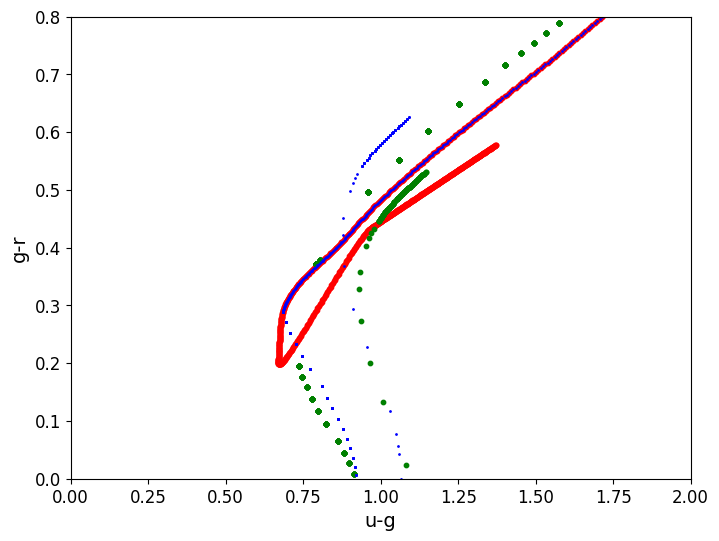

In [34]:
L = augS
fig,ax = plt.subplots(1,1,figsize=(8,6))
#ax.scatter(L['ug'], L['gr'], s=11, c=L['FeH'], cmap=plt.cm.jet) 
ax.scatter(xS['ug'], xS['gr'], c='red', s=10) 
ax.scatter(xD['ug'], xD['gr'], c='green', s=10) 
ax.scatter(augS['ug'], augS['gr'], c='blue', s=1) 
ax.set_xlim(0.0,2.0)
ax.set_ylim(0, 0.8)
ax.set_xlabel('u-g')
ax.set_ylabel('g-r') 

Text(0, 0.5, 'Mr')

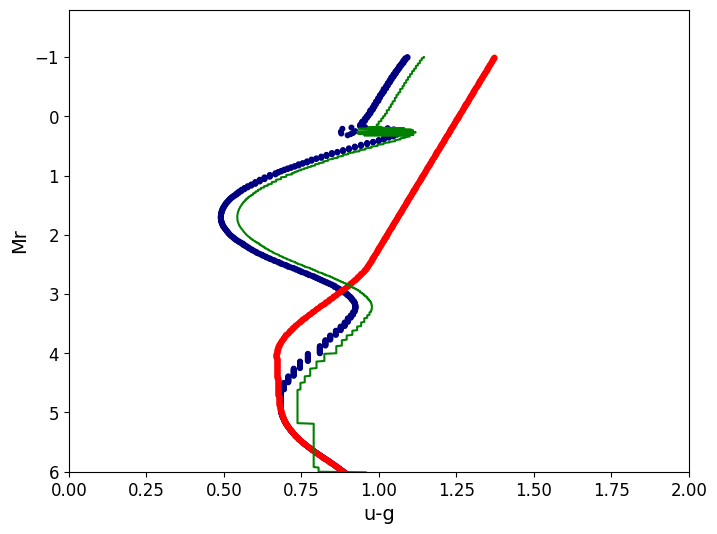

In [35]:
L = augS
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(L['ug'], L['Mr'], s=11, c=L['FeH'], cmap=plt.cm.jet) 
ax.scatter(xS['ug'], xS['Mr'], c='red', s=10) 
ax.plot(xD['ug'], xD['Mr'], c='green') 
ax.set_xlim(0.0,2.0)
ax.set_ylim(6, -1.8)
ax.set_xlabel('u-g')
ax.set_ylabel('Mr') 

Text(0, 0.5, 'Mr')

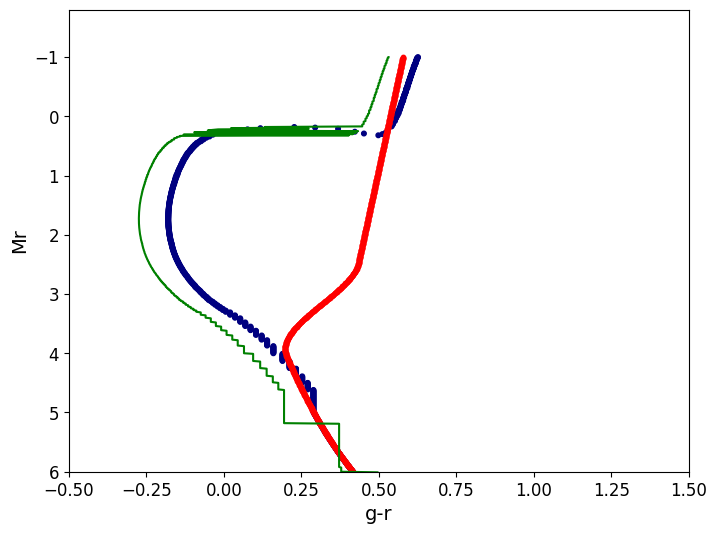

In [36]:
L = augS
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(L['gr'], L['Mr'], s=11, c=L['FeH'], cmap=plt.cm.jet) 
ax.scatter(xS['gr'], xS['Mr'], c='red', s=10) 
ax.plot(xD['gr'], xD['Mr'], c='green') 
ax.set_xlim(-0.5,1.5)
ax.set_ylim(6, -1.8)
ax.set_xlabel('g-r')
ax.set_ylabel('Mr') 

Text(0, 0.5, 'g-r')

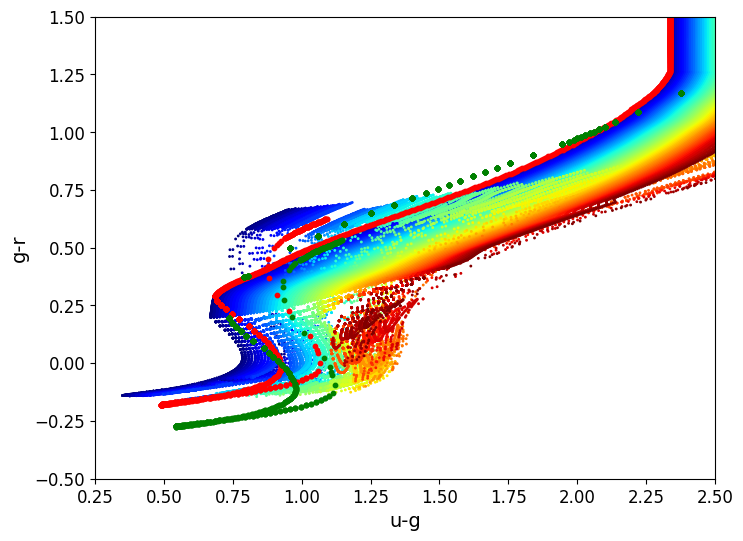

In [37]:
L=locusSDSS1
O = augS
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(L['ug'], L['gr'], s=1.1, c=L['FeH'], cmap=plt.cm.jet) 
ax.scatter(O['ug'], O['gr'], c='red', s=10) 
ax.scatter(xD['ug'], xD['gr'], c='green', s=10) 
ax.set_xlim(0.25,2.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel('u-g')
ax.set_ylabel('g-r') 

Text(0, 0.5, 'Mr')

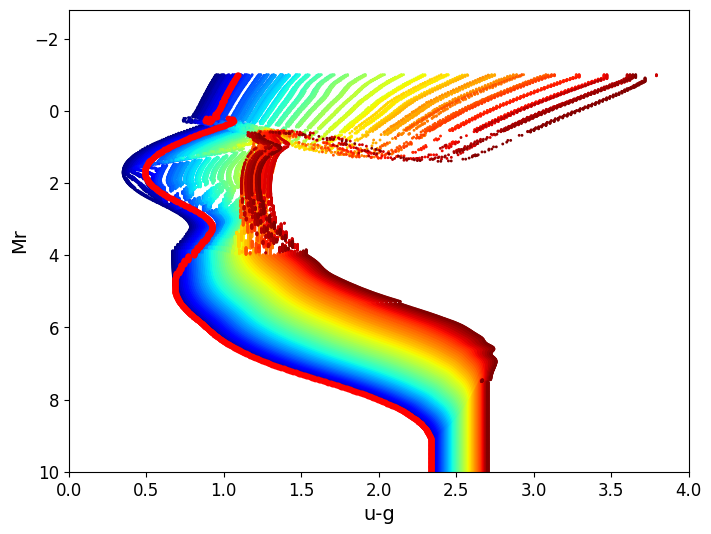

In [38]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(L['ug'], L['Mr'], s=1.1, c=L['FeH'], cmap=plt.cm.jet) 
ax.scatter(O['ug'], O['Mr'], c='red', s=10) 
ax.set_xlim(0.0,4.0)
ax.set_ylim(10, -2.8)
ax.set_xlabel('u-g')
ax.set_ylabel('Mr') 

Text(0, 0.5, 'Mr')

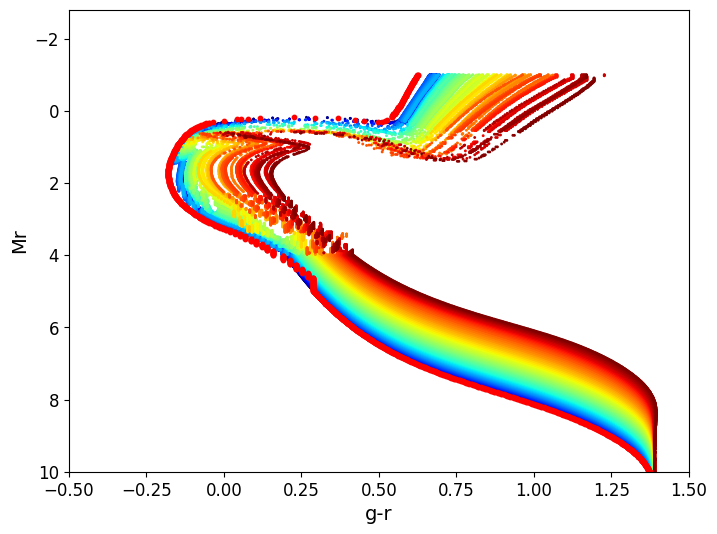

In [39]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(L['gr'], L['Mr'], s=1.1, c=L['FeH'], cmap=plt.cm.jet) 
ax.scatter(O['gr'], O['Mr'], c='red', s=10) 
ax.set_xlim(-0.5,1.5)
ax.set_ylim(10, -2.8)
ax.set_xlabel('g-r')
ax.set_ylabel('Mr') 

made plot: compare2isochrones_augmentedSDSS_1Gyr_10Gyr.png


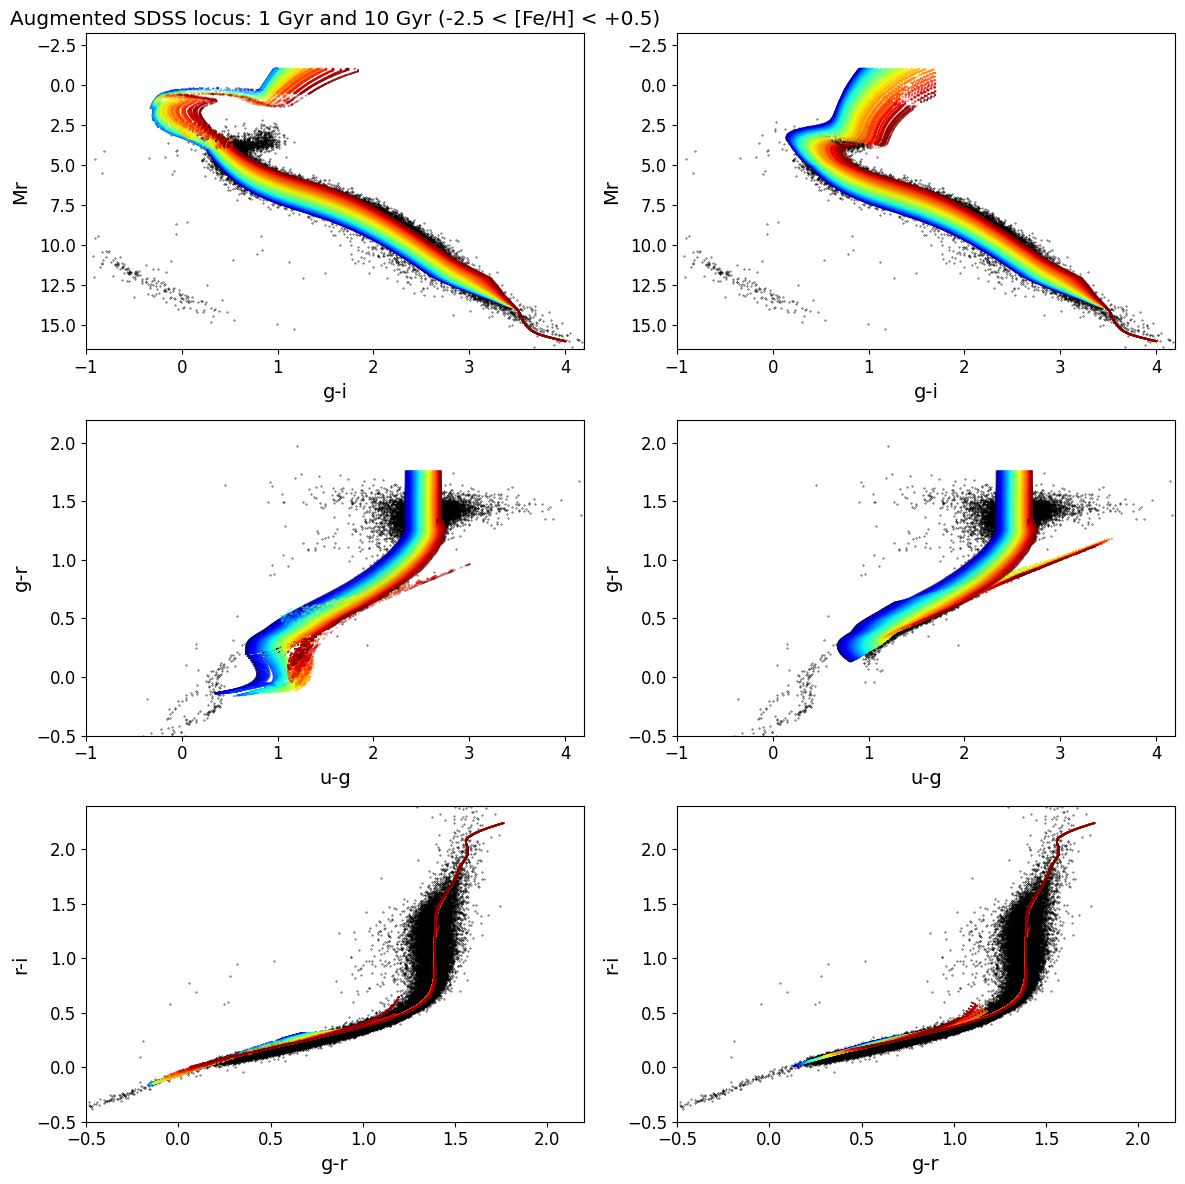

In [40]:
Pdf1 = locusSDSS1
flag = (locusSDSS1['FeH']>-2.6)&(locusSDSS1['Mr']>-10)
xx1 = locusSDSS1[flag]
Pdf1 = xx1
flag = (locusSDSS10['gi']>1.7)&(locusSDSS10['Mr']<2.5)
xx2 = locusSDSS10[~flag]
Pdf2 = xx2
pname = 'compare2isochrones_augmentedSDSS_1Gyr_10Gyr.png'
title = 'Augmented SDSS locus: 1 Gyr and 10 Gyr (-2.5 < [Fe/H] < +0.5)'
pp.compare2isochrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.5, alpha2=0.5, title=title, plotname=pname)

In [41]:
L = locusSDSS10[locusSDSS10['FeH']>0.46]

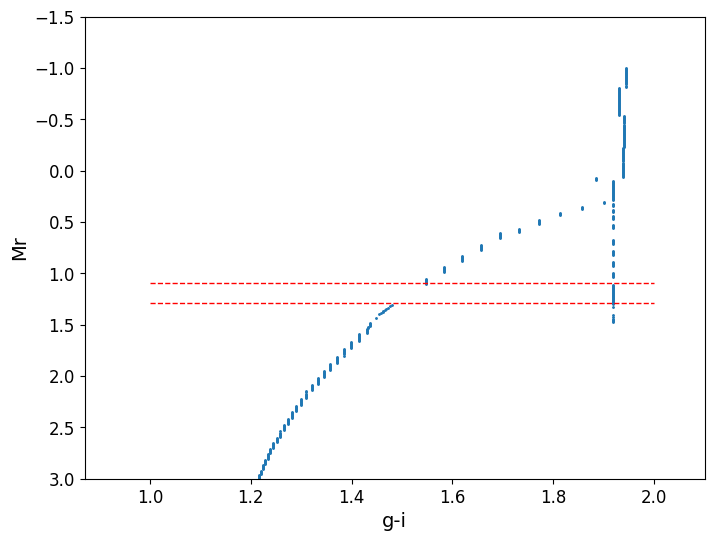

In [42]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(L['gi'], L['Mr'], s=1.1) 
ax.set_xlim(0.0,3.7)
ax.set_ylim(17.0, -1.9)
ax.set_xlabel('g-i')
ax.set_ylabel('Mr')
ax.set_xlim(0.87,2.1)
ax.set_ylim(3.0, -1.5)
ax.plot([1, 2], [1.09, 1.09], '--r', lw=1)
ax.plot([1, 2], [1.29, 1.29], '--r', lw=1)

## PARSEC isochrones

In [44]:
# assumes this notebook is called from directory ./PhotoD/notebooks/ 
datafile = '../data/PARSEC/PARSEC_logAge10.0_FeHgrid.txt'
P10 = lt.PARSEClocus(datafile)
P10i = lt.interpolateLocusGrid(P10, Lok) 
 
FeH0 = FeHlocus3vals[0]
FeH1 = FeHlocus3vals[0] 
FeH2 = FeHlocus3vals[0] 
Pdf = P10 
P0 = Pdf[(Pdf['FeH']>FeH0-0.01)&(Pdf['FeH']<FeH0+0.01)]
P1 = Pdf[(Pdf['FeH']>FeH1-0.01)&(Pdf['FeH']<FeH1+0.01)]
P2 = Pdf[(Pdf['FeH']>FeH2-0.01)&(Pdf['FeH']<FeH2+0.01)]
Ps = []
Ps.append(P0)
Ps.append(P1)
Ps.append(P2) 

made plot: plot3HRdiags.png


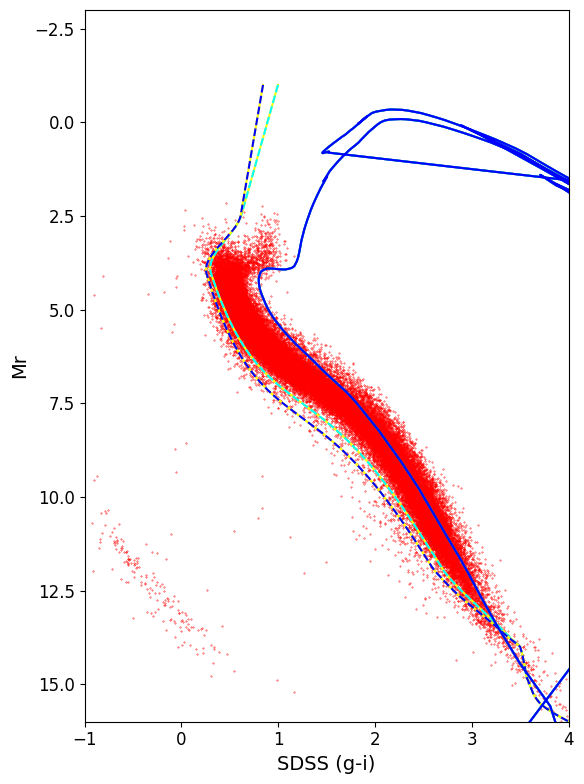

made plot: showUGR.png


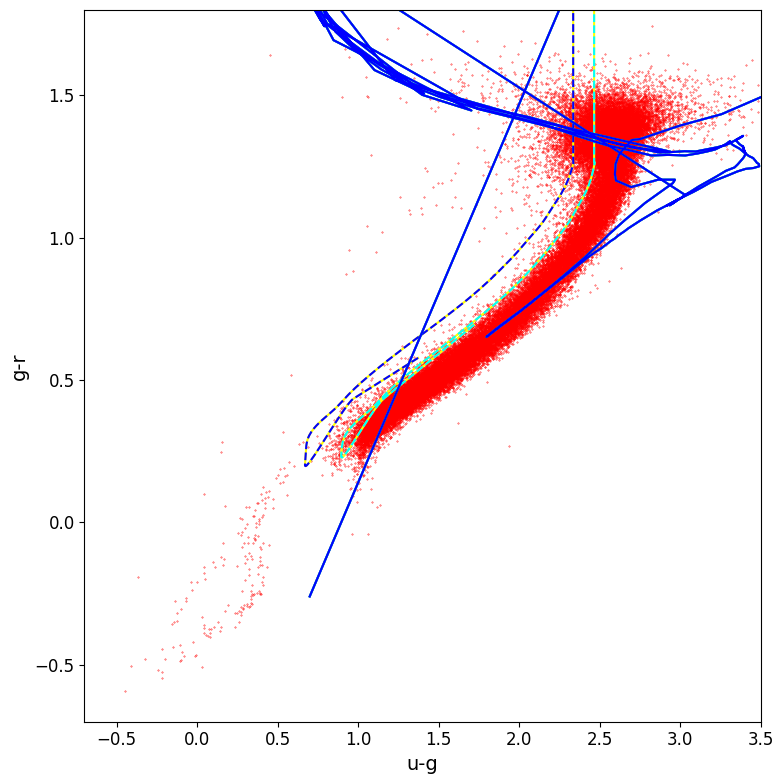

made plot: showGRI.png


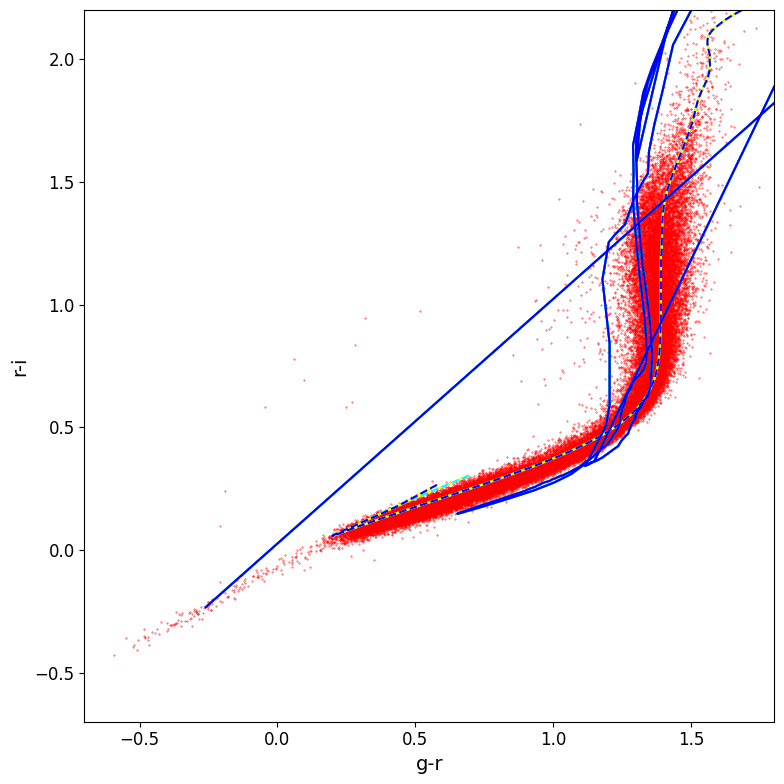

made plot: showRIZ.png


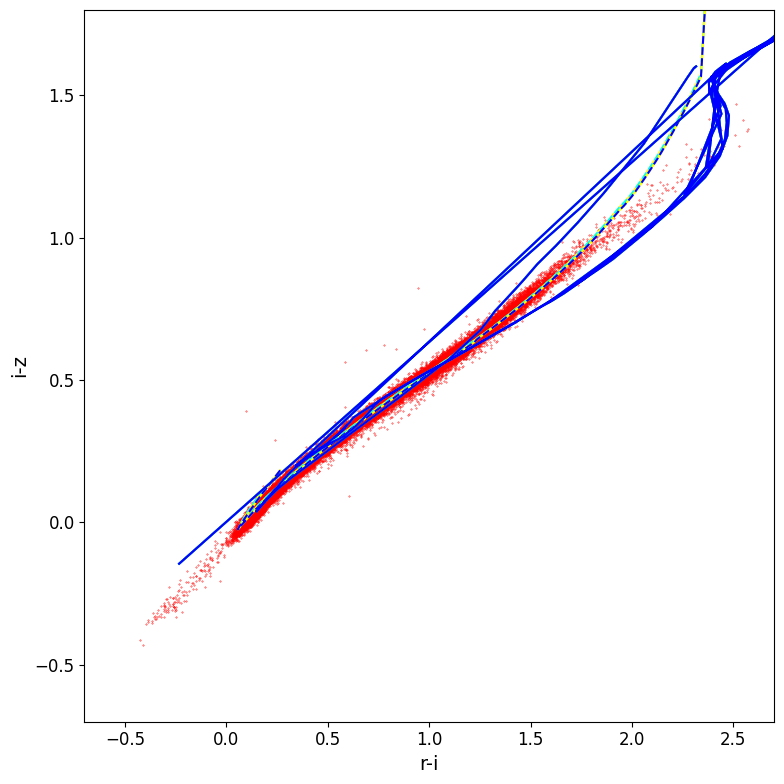

In [45]:
pp.showHR(s82gaiaPi, Ls, Ps)
pp.showUGR(s82gaiaPi, Ls, Ps)
pp.showGRI(s82gaiaPi, Ls, Ps)
pp.showRIZ(s82gaiaPi, Ls, Ps)

In [46]:
!cp plot3HRdiags.png plot3HRdiags_compareSDSS2Parsec.png
!cp showUGR.png showUGR_compareSDSS2Parsec.png
!cp showGRI.png showGRI_compareSDSS2Parsec.png
!cp showRIZ.png showRIZ_compareSDSS2Parsec.png

made plot: plot3HRdiags.png


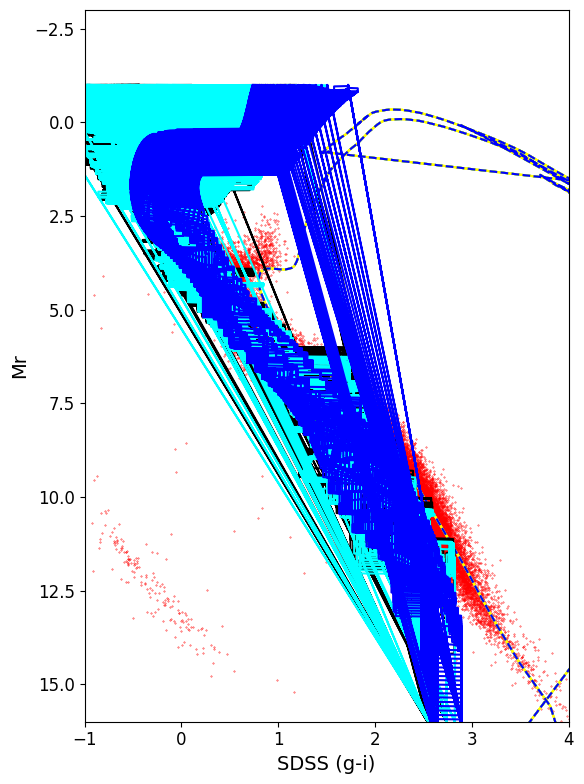

In [48]:
pp.showHR(s82gaiaPi, Ps, DSEDlociiInterp)
#pp.showUGR(s82gaiaPi, Ps, DSEDs)
#pp.showGRI(s82gaiaPi, Ps, DSEDs)
#pp.showRIZ(s82gaiaPi, Ps, DSEDs)

In [49]:
!cp plot3HRdiags.png plot3HRdiags_compareParsec2DSED.png
!cp showUGR.png showUGR_compareParsec2DSED.png
!cp showGRI.png showGRI_compareParsec2DSED.png
!cp showRIZ.png showRIZ_compareParsec2DSED.png

In [50]:
Pdf1 = P10
Pdf2 = DSEDlocii[ages.index(13)] 
print('PARSEC, FeH range:', np.min(Pdf1['FeH']), np.max(Pdf1['FeH']))
print('DSED, FeH range:', np.min(Pdf2['FeH']), np.max(Pdf2['FeH']))
pname = 'compare2isocrones_PARSECvsDSED13Gyr.png'
title = 'PARSEC vs. DSED, 13 Gyr'
pp.compare2isocrones(s82gaiaPi, Pdf1, Pdf2, alpha1=0.8, alpha2=0.8, title=title, plotname=pname)

PARSEC, FeH range: -2.19174 0.5
DSED, FeH range: -2.5 0.5


AttributeError: module 'paperPlots' has no attribute 'compare2isocrones'

## Bob Abel's white dwarf locii

In [52]:
import pandas as pd

In [54]:
datafile = '../../BobAbel/White-Dwarfs/WD.csv'
WD = pd.read_csv(datafile)
datafile = '../../BobAbel/White-Dwarfs/WDMD.csv'
WDMD = pd.read_csv(datafile)

made plot: plot3diagsBA.png


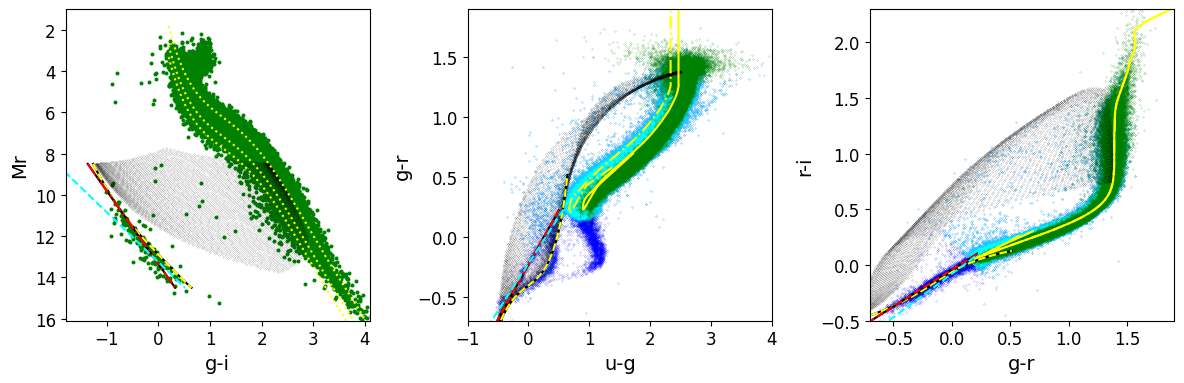

In [55]:
pp.plot3diagsBobAbel(s82gaia, s82gaiaB, s82gaiaPhD, s82gaiaPi, L0, L1, L2, WD, WDMD) 

made plot: plot3diagsBA.png


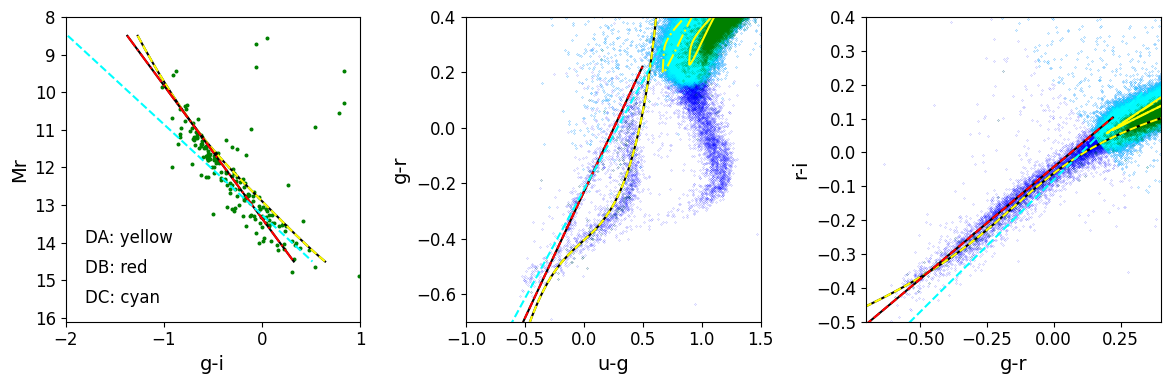

In [56]:
pp.plot3diagsBobAbel(s82gaia, s82gaiaB, s82gaiaPhD, s82gaiaPi, L0, L1, L2, WD, WDMD, zoom=True)

## dump SDSS-Gaia data files for Bob Abel

In [57]:
t = s82gaiaPi
st = Table([t['ug'], t['gr'], t['ri'], t['iz'], t['Mr']],
           names=('ug', 'gr', 'ri', 'iz', 'Mr'),
           meta={'name': 's82gaiaPi'})
st.write('s82gaiaPi.csv', format='ascii', delimiter=',', overwrite=True) 

In [58]:
t = s82gaiaB
st = Table([t['ug'], t['gr'], t['ri'], t['iz'], t['MrPho']],
           names=('ug', 'gr', 'ri', 'iz', 'Mr'),
           meta={'name': 's82gaiaB'})
st.write('s82gaiaB.csv', format='ascii', delimiter=',', overwrite=True) 